In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels
import scipy.optimize as op
import emcee

In [6]:
newdata = pd.read_table('PDCMAP.txt', sep='\s+')

In [7]:
alltime= np.array(newdata['Time'], 'd')
allflux = np.array(newdata['Pdcmap'], 'd')
allquarter = np.array(newdata['Quarter'], 'd')

14701 64024


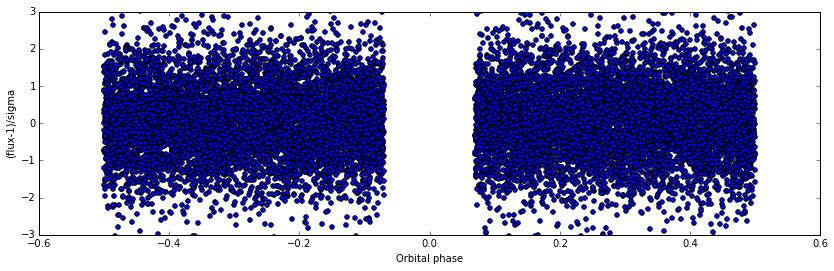

In [8]:
flag = np.zeros(len(alltime), dtype=bool)
quarters = np.unique(allquarter)

# Renormalize each quarter and remove outliers
for q in quarters:
    sel = allquarter == q
    errorf = np.std(allflux[sel])
    medianf = np.median(allflux[sel])
    finsel = np.logical_and(allquarter == q, (np.abs(allflux-medianf) <= 4.0*errorf))
    allflux[finsel] = allflux[finsel]/np.median(allflux[finsel])
    flag[finsel] = True
    
# Remove points in transit
t0 = 53.1910
p = 0.6892099

phasesaux = (alltime-t0)/p
phases = phasesaux - np.around(phasesaux)
flag[np.abs(phases) < 0.07]= False
flag[allquarter < 9]= False
flag[allquarter > 12]= False



    
#Retain the right points
print np.sum(flag), len(flag)
time = alltime[flag]
flux = allflux[flag] -1.0
flux = flux/np.std(flux)
quarter = allquarter[flag]
phases = phases[flag]

#plot the folded light curve to make sure we removed transits
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(phases, flux)
plt.ylim([-3,3]) 
ax.set_ylabel('(flux-1)/sigma')
ax.set_xlabel('Orbital phase')

In [9]:
interval = 1.0 # sum invertal in days
start = np.min(time) + 0.5*interval
end = (np.around((np.max(time)-start)/interval) + 1)*interval + start
numint = (end-start)/interval

newcenters = np.linspace(start, end, numint+1, endpoint=True)
newtimes = np.empty_like(newcenters)
newfluxes = np.empty_like(newtimes)
numpoints = np.empty_like(newtimes)
newerrors = np.empty_like(newtimes)
newquarter = np.empty_like(newtimes)

for i, t0 in enumerate(newtimes):
    selected = np.abs(time-newcenters[i]) < interval*0.5
    numpoints[i] = np.sum(selected)
    if numpoints[i] > 1:
        selflux = flux[selected]
        seltimes= time[selected]
        t1 = np.median(seltimes)
        newtimes[i]  = t1
        result = np.polyfit(seltimes-t1, selflux, 1)
        newfluxes[i] = result[1] 
        newerrors[i] = np.std(selflux-result[1]-result[0]*(seltimes-t1))/np.sqrt(numpoints[i])
        newquarter[i] = np.median(quarter[selected])


        
cadence = 29.42/(60.0*24)
        
newtimes = newtimes[numpoints > interval*0.75/cadence]
newfluxes = newfluxes[numpoints > interval*0.75/cadence]
newerrors = newerrors[numpoints > interval*0.75/cadence]

<Container object of 3 artists>

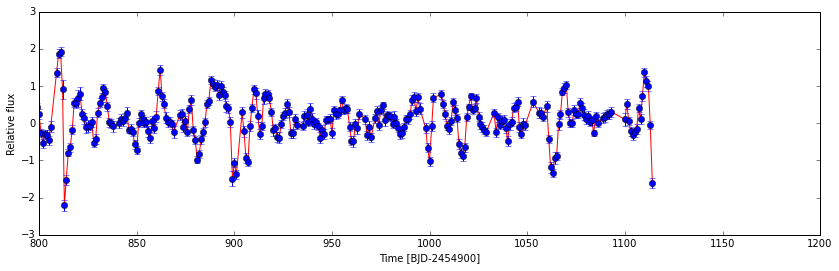

In [10]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
#ax.scatter(time, flux)
plt.xlim([800,1200]) 
plt.ylim([-3,3]) 
ax.set_xlabel('Time [BJD-2454900]')
ax.set_ylabel('Relative flux')
ax.plot(newtimes, newfluxes, 'r')
ax.errorbar(newtimes, newfluxes, yerr=newerrors, fmt='o')

In [11]:
def lnlike(theta, time, flux, error, prot):
    loggamma, logh, logalpha, sigma = theta
    
    gamma = 10**loggamma
    alpha = 10**logalpha
    h = 10**logh
    
    gp = george.GP(kernels.WhiteKernel(sigma**2)+
                   (kernels.ExpSquaredKernel(alpha**2)*(kernels.ExpSine2Kernel(1.0/gamma**2, prot))*h**2))
    gp.compute(time, error)
    return gp.lnlikelihood(flux)

In [12]:
def lnprior(theta):
    loggamma, logh, logalpha, sigma = theta
    
    gamma = 10**loggamma
    alpha = 10**logalpha
    h = 10**logh
    
    if (3.0 < alpha <= 100.0) and (3.0 <= gamma <= 100) and (0.01 <= h) and (0.0001 < sigma):
        return 0.0
    return -np.inf

In [13]:
def lnprob(theta, time, flux, error, prot):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, time, flux, error, prot)

In [16]:
nll = lambda *args: -lnprob(*args)

allperiods = np.linspace(2.0, 70.0, 50.0)
minvals = np.empty_like(allperiods)
status = np.empty_like(allperiods)
alphavals = np.empty_like(allperiods)
hvals = np.empty_like(allperiods)
gammavals = np.empty_like(allperiods)
sigmavals = np.empty_like(allperiods)



for i, prot in enumerate(allperiods):
    result = op.minimize(nll, [1.0, -1.0, 1.0, 0.5],  method='nelder-mead',
                     args=(newtimes, newfluxes, 0.001*newerrors, prot), tol=0.001, options={'disp': False, 'maxiter':100000})
    gammavals[i], hvals[i], alphavals[i], sigmavals[i] = result["x"]  
    minvals[i] = result["fun"]
    status[i] = result["status"]

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


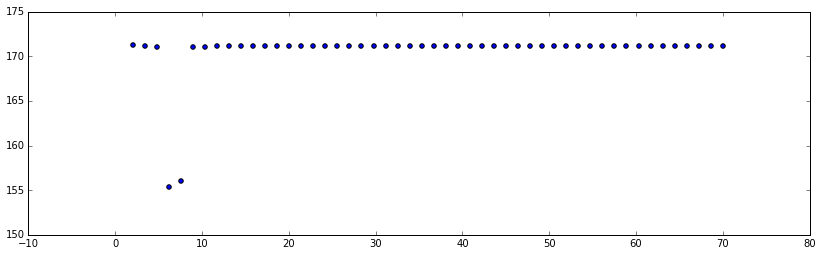

In [17]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,1,1)
ax.scatter(allperiods, minvals)
print status

In [39]:
ndim, nwalkers = 5, 20
pos = [result["x"]*(1+5e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [40]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(newtimes, newfluxes, newerrors))
sampler.run_mcmc(pos, 200);

In [41]:
samples = sampler.chain[:, 20:, :].reshape((-1, ndim)) #Burn in portion to remove (currently %10)

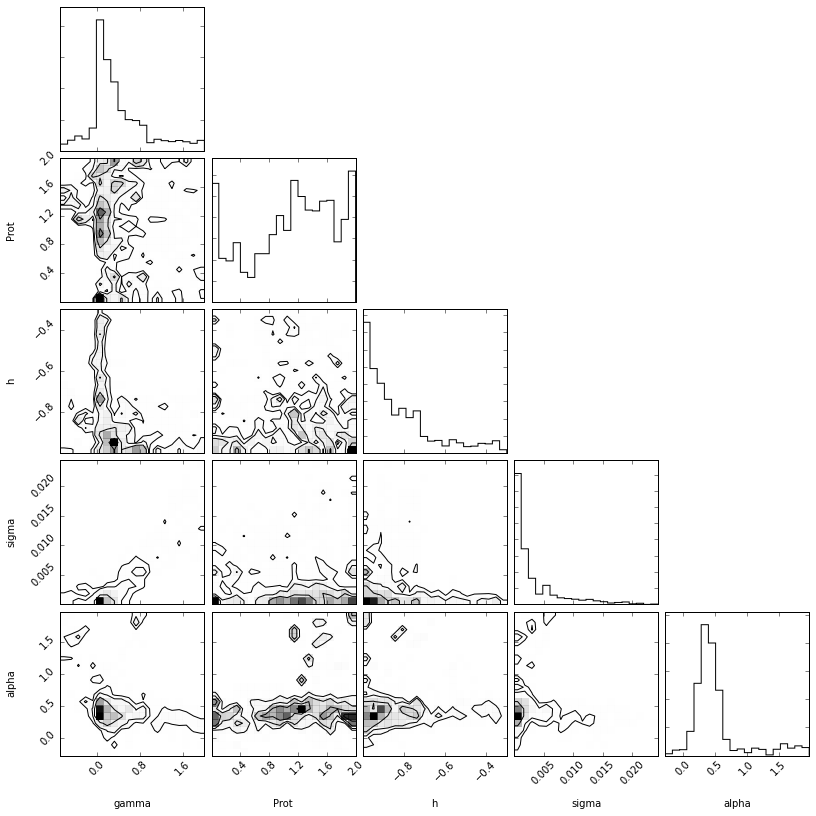

In [42]:
import triangle
fig = triangle.corner(samples, labels=["gamma", "Prot", "h", "sigma", "alpha"]) #truths=[m_true, b_true, np.log(f_true)   , 
fig.savefig("triangle.png")

In [216]:
(gamma_mcmc, prot_mcmc, h_mcmc, sigma_mcmc, alpha_mcmc) = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                  zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

In [217]:
print('Gamma value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(gamma_mcmc[0],gamma_mcmc[1], gamma_mcmc[2] ))
print('Prot value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(prot_mcmc[0],prot_mcmc[1], prot_mcmc[2] ))
print('Alpha value {0:3.2f} +{1:3.2f} - {1:3.2f}' .format(alpha_mcmc[0],alpha_mcmc[1], alpha_mcmc[2] ))

Gamma value 18.82 +90.79 - 90.79
Prot value 55.31 +30.61 - 30.61
Alpha value 37.63 +44.75 - 44.75
